This notebook contains code for SVM result analysis


# Environment setup

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
mp.rcParams['figure.dpi'] = 300

# Import results

In [80]:
class ResEvaluator(object):
    
    def __init__(self, abstract, labels, prediction, pred_prob):
        self.abstract = abstract
        self.labels = labels
        self.prediction = prediction
        self.pred_prob = pred_prob
        self.false_positives = np.sum((self.prediction == 1) & (self.labels == 0))
        self.false_negatives = np.sum((self.prediction == 0) & (self.labels == 1))
        self.true_positives = np.sum((self.prediction == 1) & (self.labels == 1))
        self.true_negatives = np.sum((self.prediction == 0) & (self.labels == 0))
        self.accuracy = (self.true_positives + self.true_negatives)/(self.true_positives + self.true_negatives + self.false_positives + self.false_negatives)
        self.precision = (self.true_positives)/(self.true_positives + self.false_positives)
        self.recall = (self.true_positives)/(self.true_positives + self.false_negatives)
        self.f1 = (2 * self.precision * self.recall)/(self.precision + self.recall)
        
    @classmethod
    def from_tsv(cls, data_tsv, prediction_tsv, pred_prob_tsv):
        data = pd.read_csv(data_tsv, sep='\t')
        prediction = pd.read_csv(prediction_tsv, sep='\t', names=['pred'])
        pred_prob = pd.read_csv(pred_prob_tsv, sep='\t', names=['negative', 'positive'])
        return cls(abstract=data['text'], labels=data['id'], prediction=prediction['pred'], pred_prob=pred_prob)


## Import results from train-dev-test split

In [131]:
svm_res = ResEvaluator.from_tsv(
    data_tsv='/mnt/storage/projects/cs-273/dataset/train_dev_test/test.tsv',
    prediction_tsv='/mnt/storage/projects/cs-273/svm/results/test_pred.txt',
    pred_prob_tsv='/mnt/storage/projects/cs-273/svm/results/test_pred_prob.txt'
)

## Import results from 5-fold validation

In [130]:
svm_cv_res = [ResEvaluator.from_tsv(
    data_tsv='/mnt/storage/projects/cs-273/dataset/cross_validation/set_{}/dev.tsv'.format(set_ix + 1),
    prediction_tsv='/mnt/storage/projects/cs-273/svm/results_cv/cv_test_pred_set_{}.txt'.format(set_ix + 1),
    pred_prob_tsv='/mnt/storage/projects/cs-273/svm/results_cv/cv_test_pred_prob_set_{}.txt'.format(set_ix + 1)
) for set_ix in range(5)]

# Results
## Single train-dev-test split results
### Statistics

In [132]:
statistics = ['accuracy', 'precision', 'recall', 'f1']
for stat in statistics:
    print('{}:\t{}'.format(stat, svm_res.__dict__[stat]))

accuracy:	0.9646464646464646
precision:	0.7857142857142857
recall:	0.7333333333333333
f1:	0.7586206896551724


### Estimated probability distribution

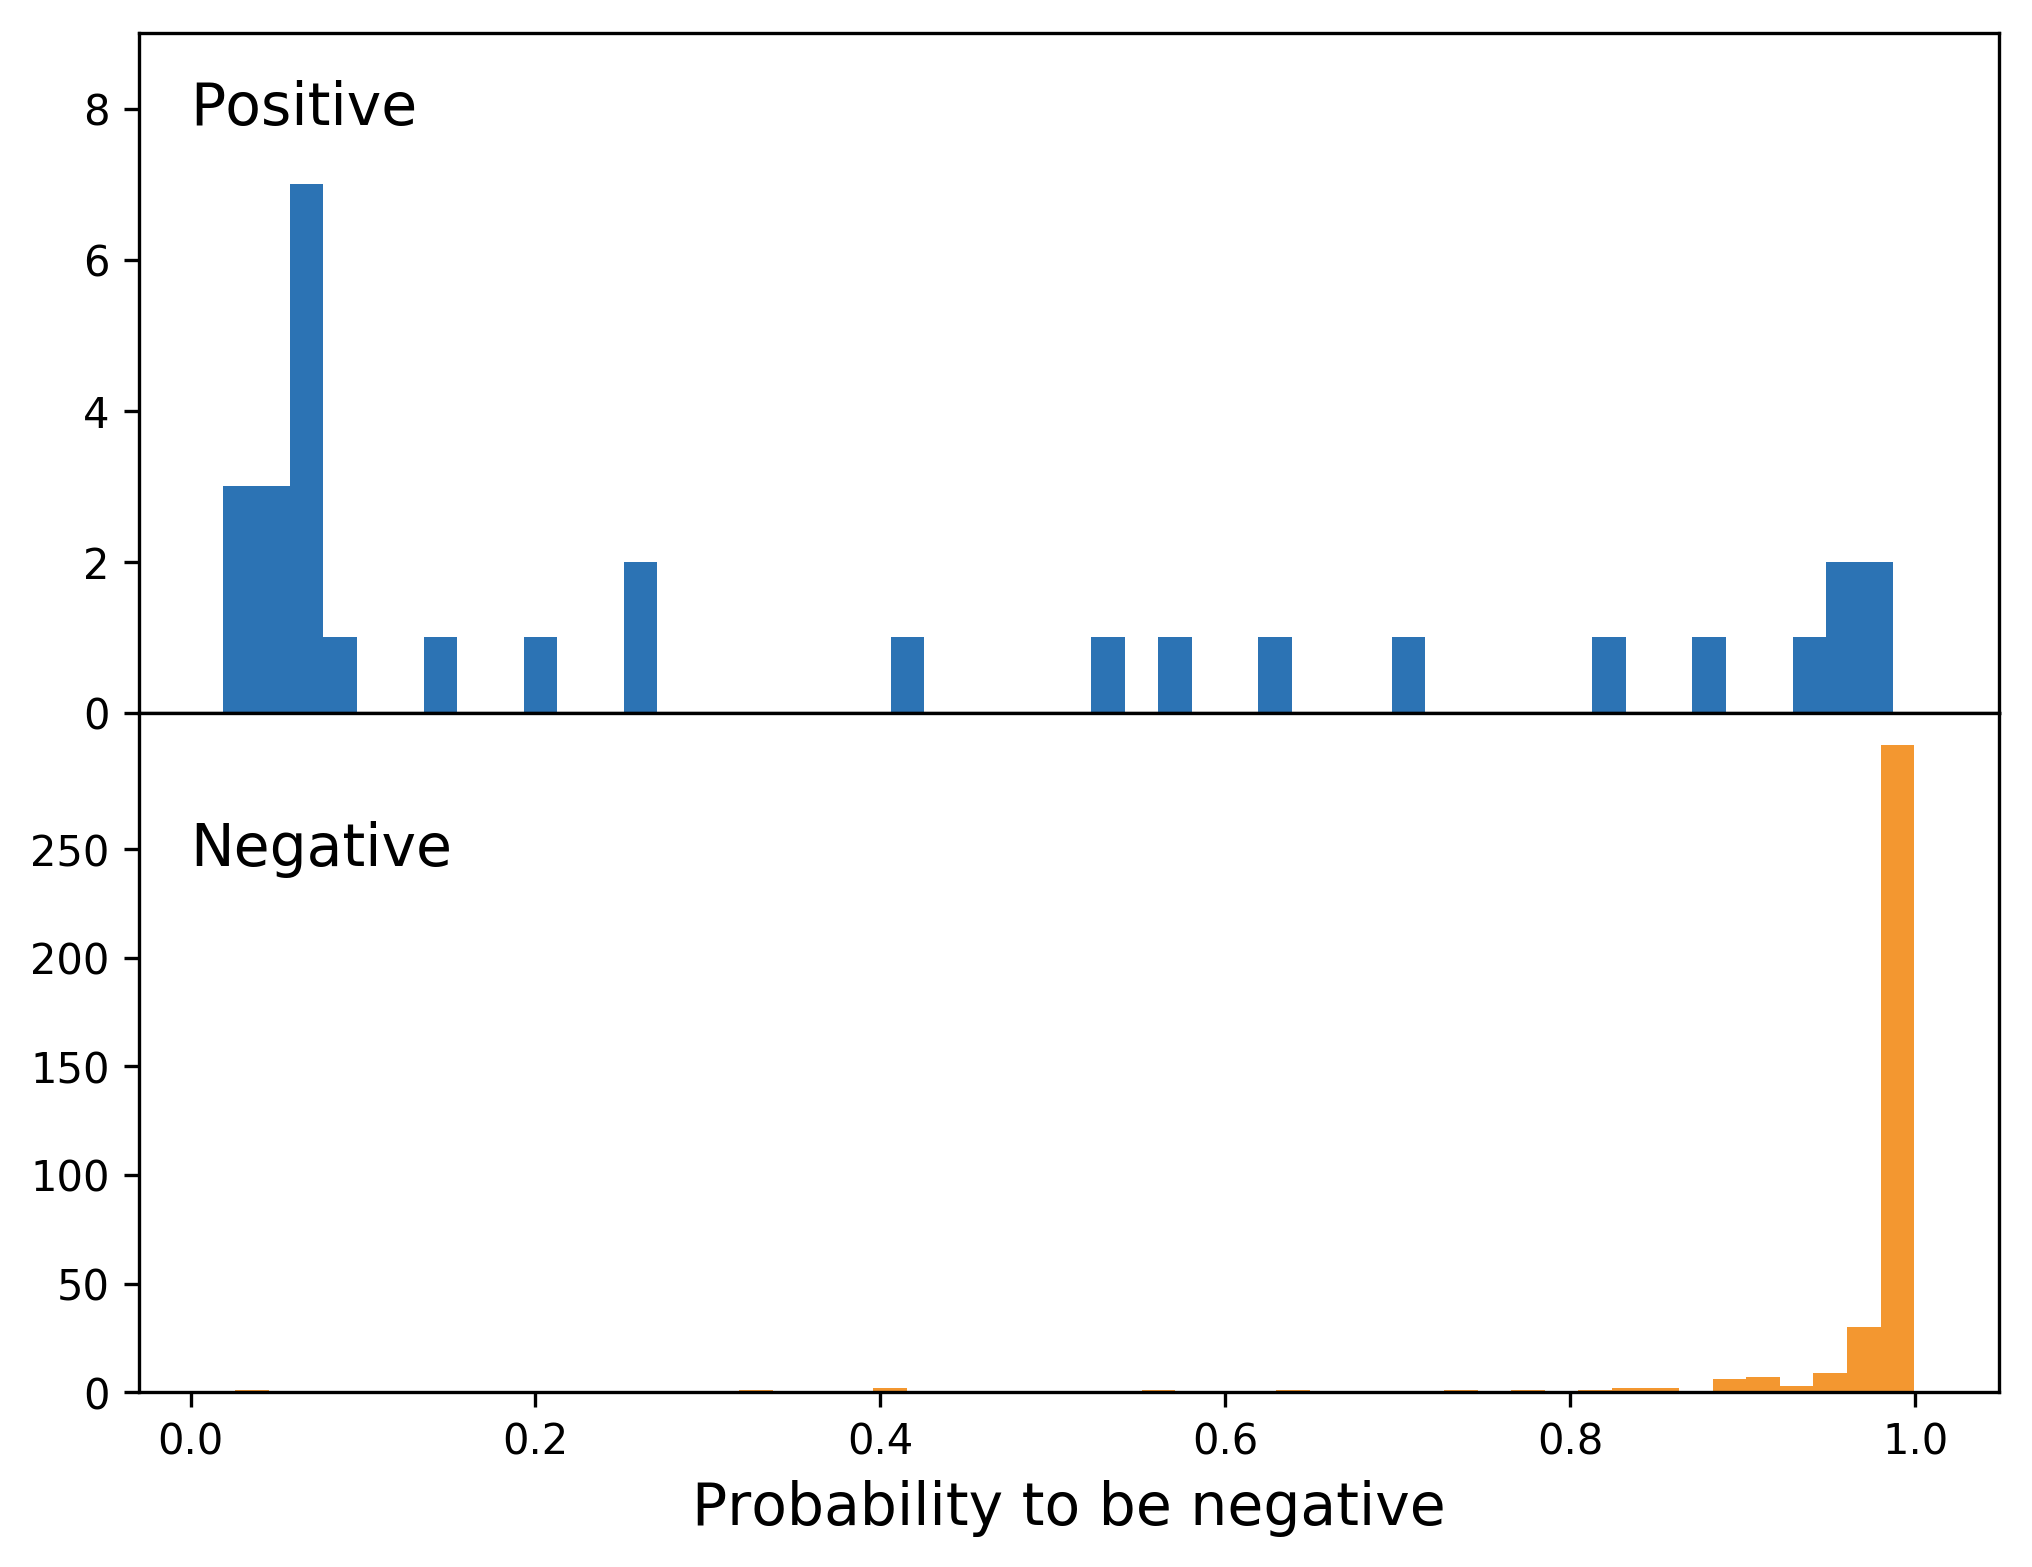

In [141]:
fig,axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
plt.subplots_adjust(hspace=0)
axes[0].hist(svm_res.pred_prob['positive'][svm_res.labels == 1], color='#2C73B4', bins=50)
axes[0].set_yticks([0, 2, 4, 6, 8])
axes[0].text(s='Positive', x=0, y=8, ha='left', va='center', fontsize=14)
axes[0].set_ylim([0, 9])
axes[1].hist(svm_res.pred_prob['positive'][svm_res.labels == 0], color='#F39730', bins=50)
axes[1].set_xlabel('Probability to be negative', fontsize=14)
axes[1].text(s='Negative', x=0,y=250, ha='left', va='center', fontsize=14)
axes[1].set_yticks([0, 50, 100, 150, 200, 250])
fig.savefig('/home/yuning/Work/cs-273/figs/svm_class_dist.jpeg', bbox_inches='tight')
plt.show()

## Cross validation results
### Statistics

In [142]:
def print_report(name, stat):
    print('{}: {} +- {}'.format(name, np.mean(stat), 2*np.std(stat, ddof=1)))
    

statistics = ['accuracy', 'precision', 'recall', 'f1']
for stat in statistics:
    print('{}:\t{}'.format(stat, [set_res.__dict__[stat] for set_res in svm_cv_res]))
    print_report(stat, [set_res.__dict__[stat] for set_res in svm_cv_res])

accuracy:	[0.9620733249051833, 0.9646017699115044, 0.9506953223767383, 0.9582806573957017, 0.9607594936708861]
accuracy: 0.9592821136520028 +- 0.010630529325371103
precision:	[0.7457627118644068, 0.7540983606557377, 0.65625, 0.7166666666666667, 0.7142857142857143]
precision: 0.7174126906945052 +- 0.07681647835680376
recall:	[0.7457627118644068, 0.7796610169491526, 0.711864406779661, 0.7288135593220338, 0.7758620689655172]
recall: 0.7483927527761542 +- 0.05879497996474249
f1:	[0.7457627118644068, 0.7666666666666666, 0.6829268292682927, 0.7226890756302521, 0.7438016528925621]
f1: 0.7323693872644361 +- 0.06344017804328574


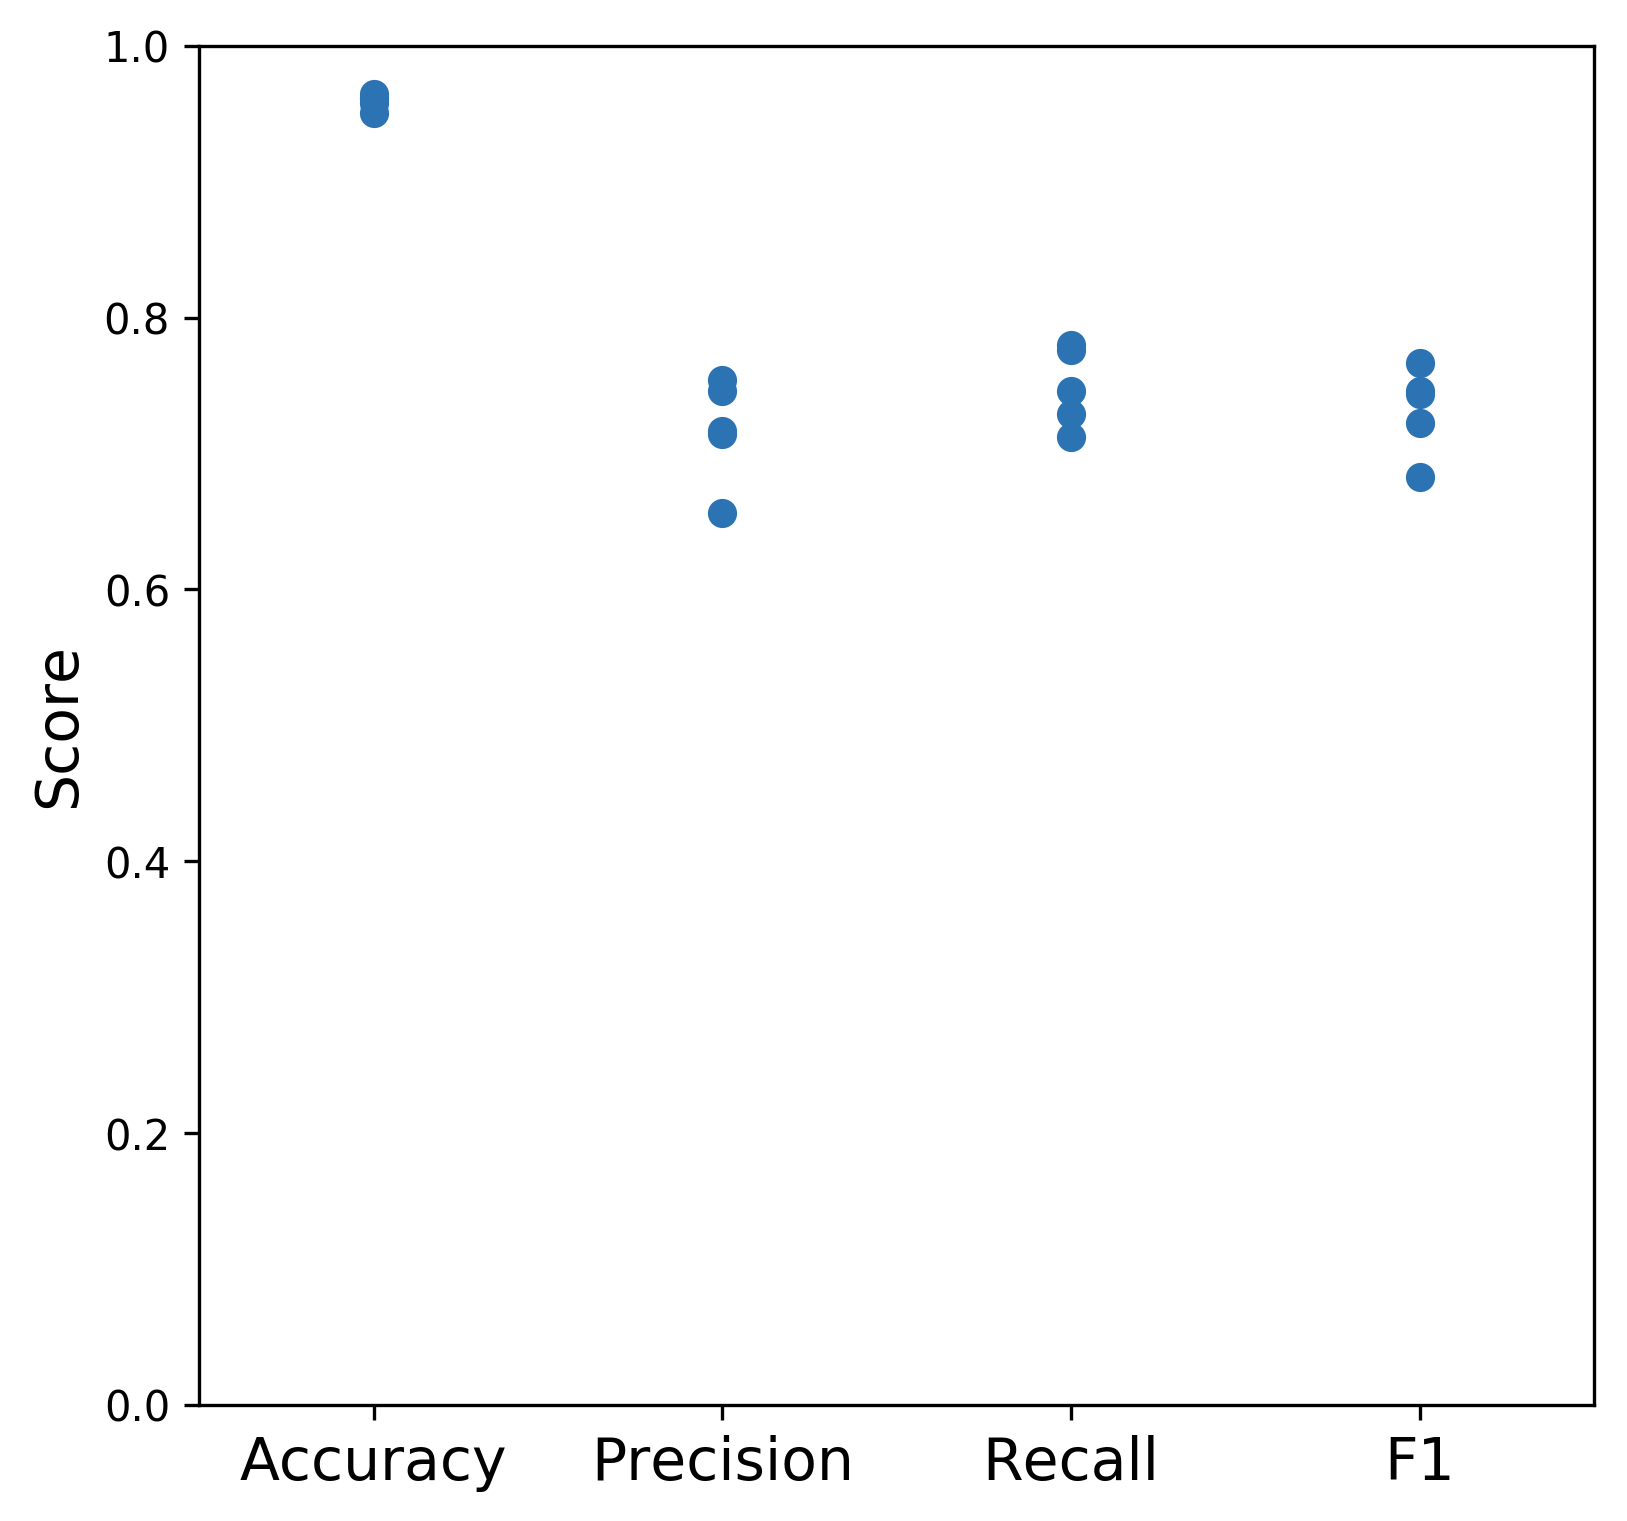

In [143]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
for ix,stat in enumerate(statistics):
    ax.scatter([ix for _ in range(5)], [set_res.__dict__[stat] for set_res in svm_cv_res], color='#2C73B4')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([stat.title() for stat in statistics], fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_ylim([0, 1])
ax.set_xlim([-0.5, 3.5])
fig.savefig('/home/yuning/Work/cs-273/figs/svm_stat_cv.jpeg')
plt.show()

### Confirm on estimated probability distribution

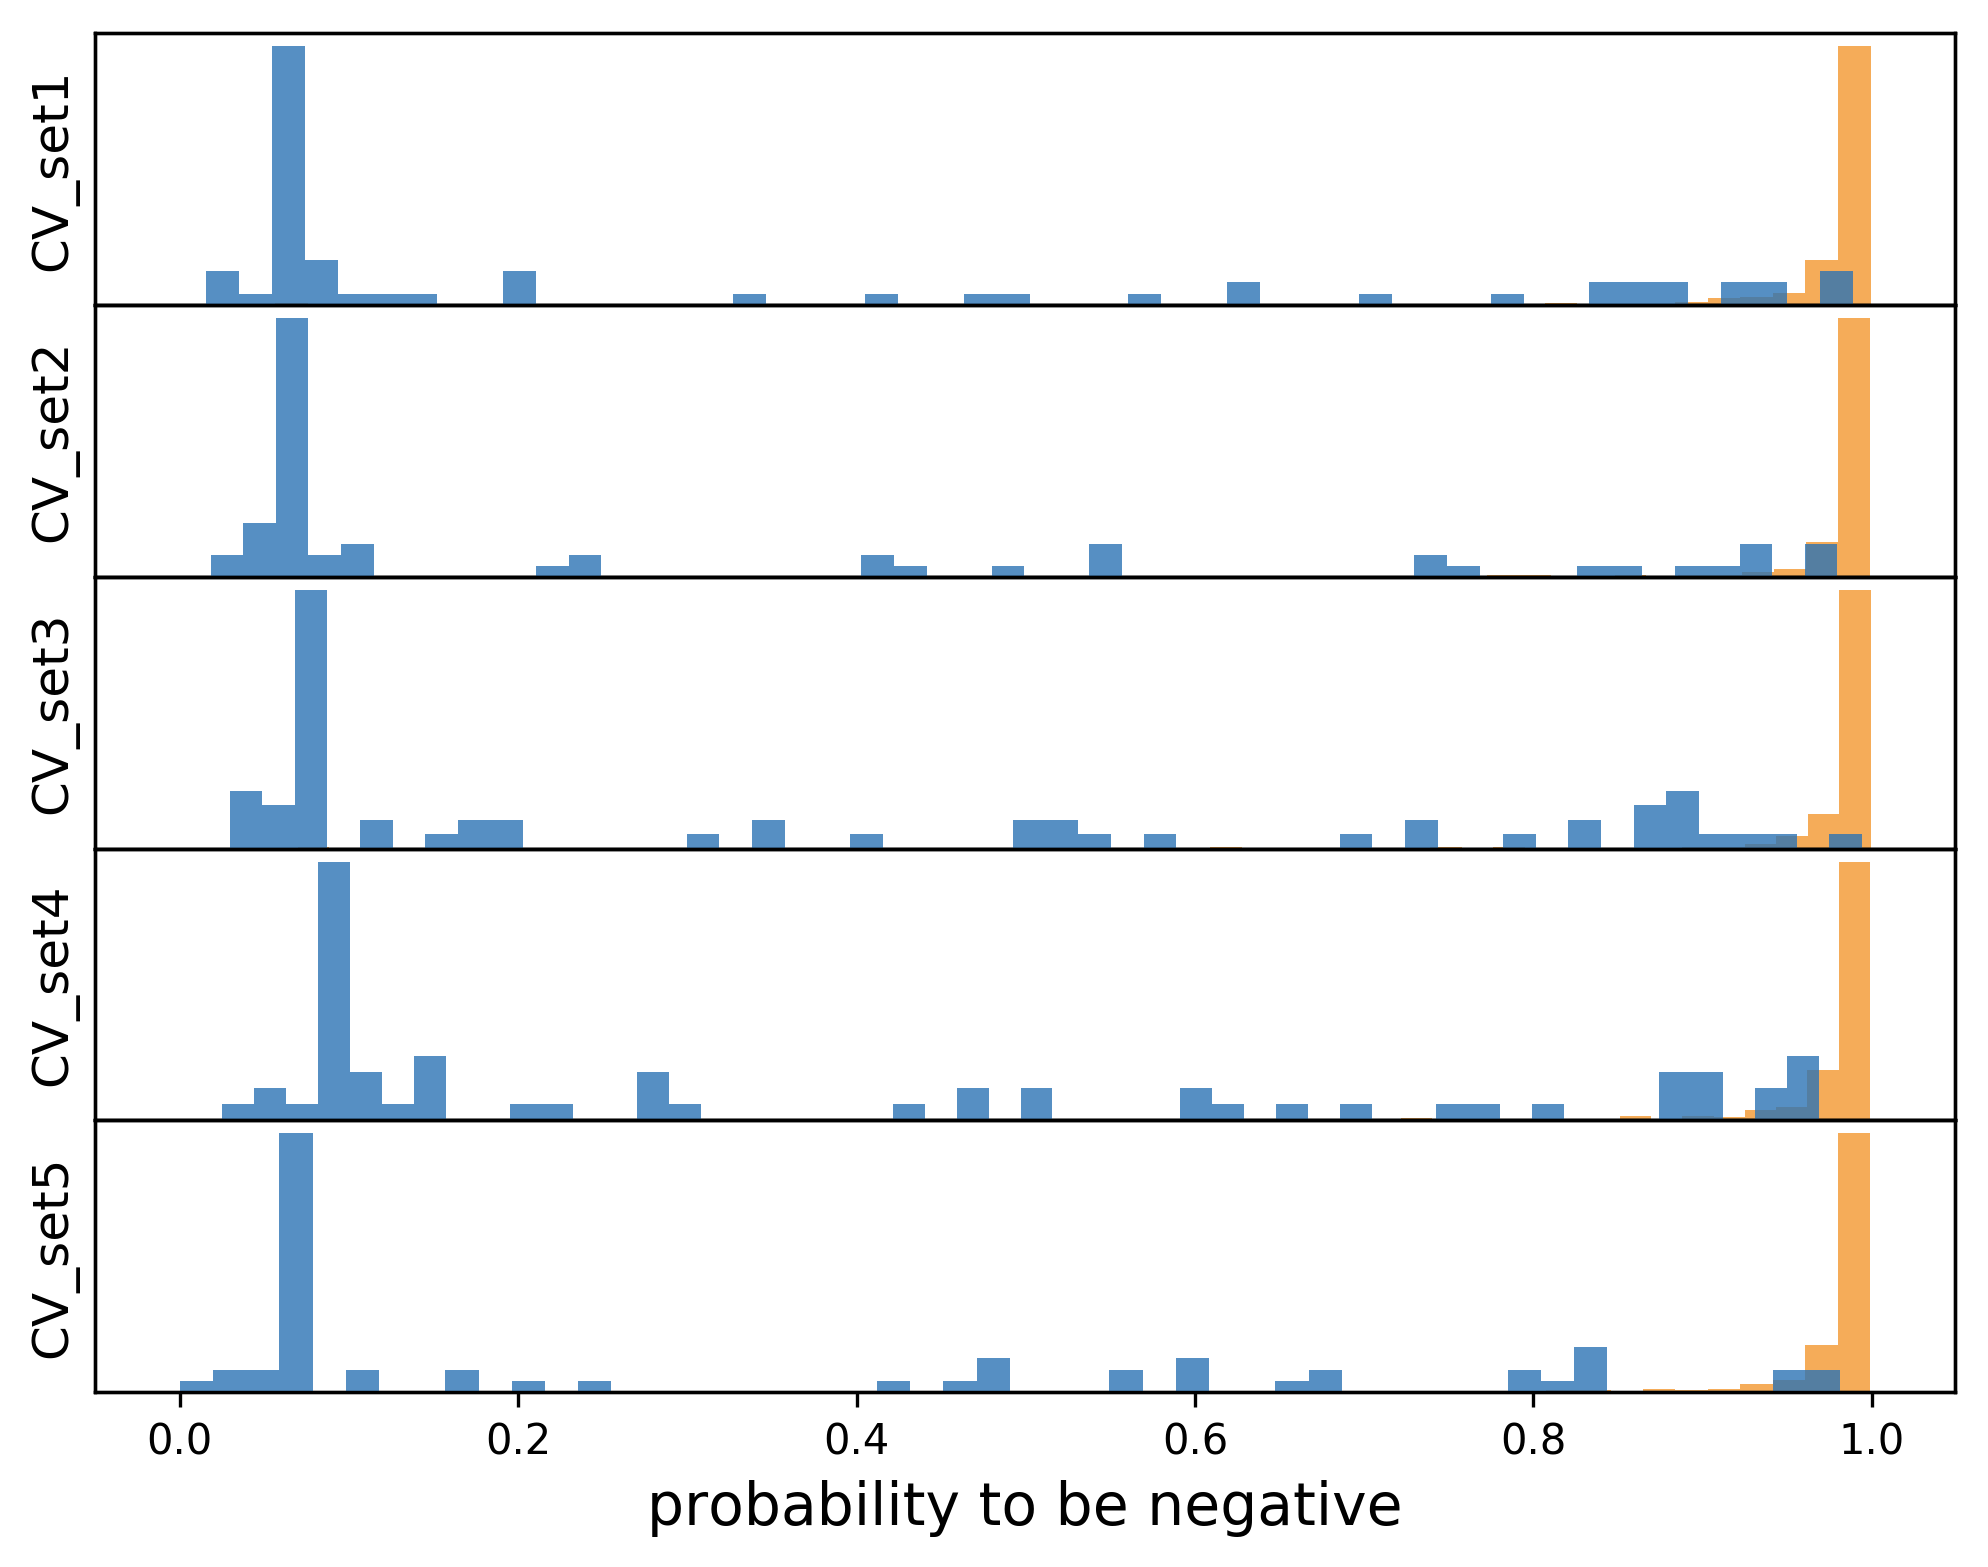

In [159]:
fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

for set_ix, set_res in enumerate(svm_cv_res):
    axes[set_ix].hist(set_res.pred_prob['positive'][set_res.labels == 0],
                      color='#F39730', bins=50, alpha=0.8, zorder=1)
    axes[set_ix].set_yticks([])
    axes[set_ix].set_ylabel('CV_set{}'.format(set_ix + 1), fontsize=12)
    ax = axes[set_ix].twinx()
    ax.hist(set_res.pred_prob['positive'][set_res.labels == 1],
                      color='#2C73B4', bins=50, alpha=0.8, zorder=0)
    ax.set_yticks([])

axes[4].set_xlabel('probability to be negative', fontsize=14)
fig.savefig('/home/yuning/Work/cs-273/figs/svm_cv_class_dist.jpeg')
plt.show()